<a href="https://colab.research.google.com/github/bGuenes/mlph2023-Exercises/blob/main/MLaP_Sheet_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b>Sheet 8 - Anomaly Detection with Autoenconders</b></h1>

For task a) to d) we can use the code given in https://github.com/heidelberg-hepml/ml-tutorials/blob/main/tutorial-9-autoencoders.ipynb. We exclude code that prints some losses (e.g. current batch loss), because it is not requested and we do not need these further informations.

<h1><b>Importing packages</b></h1>

In [1]:
import os
import numpy as np
import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import Sequential, Linear, ReLU
from tqdm.auto import tqdm

<h1><b>Plotting set-up</b></h1>

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")

# (a)

We start as usually by loading the data, preprocessing it and transforming it to images with 40x40 pixels. Then we create the needed datasets for the given tasks. Then we procede and define our autoencoder network, which consists of two MLPs:

1. ) data_dim -> hiddenlayer_size -> hiddenlayer_size -> bottleneck_size
2. ) bottleneck_size -> hiddenlayer_size -> hiddenlayer_size -> data_dim

As activation function we use ReLU. data_dim = 40x40 = 1600 is predefined by our image size. As hiddenlayer_size we choose 400 and as bottleneck_size we choose 20, as they do it in the previously linked example.

In [3]:
# We provide the data from our personal google drive
# This needs to be changed individually depending on where the data is stored
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Here the exact location of the data also needs to be selected individually

# load data
X_train = np.load( "/content/drive/MyDrive/toptagging-short/x_train_short.npy")
y_train = np.load( "/content/drive/MyDrive/toptagging-short/y_train_short.npy")
X_test = np.load( "/content/drive/MyDrive/toptagging-short/x_test_short.npy")
y_test = np.load( "/content/drive/MyDrive/toptagging-short/y_test_short.npy")
X_val = np.load( "/content/drive/MyDrive/toptagging-short/x_val_short.npy")
y_val = np.load( "/content/drive/MyDrive/toptagging-short/y_val_short.npy")

print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


In [5]:
X_train_qcd = X_train[ y_train == 0.0 ]
X_val_qcd = X_val[ y_val == 0.0 ]

In [6]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around,
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])

        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else:
        x_rot, y_rot = x, y

    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1

    return x_rot, y_rot

In [7]:
# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):

    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]

    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)

    print( "Calculating eta" )
    etas  = eta(pT,pzs)

    print( "Calculating phi" )
    phis  = phi(pxs,pys)

    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)

    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi

    print( "Using pT as weight" )
    weights = pT

    print( "Preprocessing" )

    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )

    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)

    #return z_ori

    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum

    #print( "Reshaping" )
    #z_out = z_new.reshape( (z_new.shape[0],-1) )

    return z_new#z_out

In [8]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_train = z_train.reshape( (z_train.shape[0],-1) )
z_train_qcd = constit_to_img( X_train_qcd, 50, True, True, True )
z_train_qcd = z_train_qcd.reshape( (z_train_qcd.shape[0],-1) )
z_val = constit_to_img( X_val, 50, True, True, True )
z_val = z_val.reshape( (z_val.shape[0],-1) )
z_val_qcd = constit_to_img( X_val_qcd, 50, True, True, True )
z_val_qcd = z_val_qcd.reshape( (z_val_qcd.shape[0],-1) )
z_test = constit_to_img( X_test, 50, True, True, True )
z_test = z_test.reshape( (z_test.shape[0],-1) )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising


In [9]:
print( "Train data shape: " + str(z_train.shape) )
print( "Train data (qcd-only) shape: " + str(z_train_qcd.shape) )
print( "Val data shape: " + str(z_val.shape) )
print( "Val data (qcd-only) shape: " + str(z_val_qcd.shape) )
print( "Test data shape: " + str(z_test.shape) )

Train data shape: (30000, 1600)
Train data (qcd-only) shape: (14960, 1600)
Val data shape: (30000, 1600)
Val data (qcd-only) shape: (14460, 1600)
Test data shape: (30000, 1600)


In [10]:
z_train_p = torch.Tensor( z_train )
z_train_qcd_p = torch.Tensor( z_train_qcd )
z_val_p = torch.Tensor( z_val )
z_val_qcd_p = torch.Tensor( z_val_qcd )
z_test_p = torch.Tensor( z_test )
y_train_p = torch.Tensor( y_train )
y_val_p = torch.Tensor( y_val )
y_test_p = torch.Tensor( y_test )

In [11]:
class topcloud_bkg_dataset( Dataset ):

    def __init__( self, data ):
        self.data = data
        self.labels = torch.Tensor( [ 0.0 for i in range(len(data)) ] )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class topcloud_sig_dataset( Dataset ):

    def __init__( self, data, labels ):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [12]:
trn_dataset = topcloud_bkg_dataset( z_train_qcd_p )
val_dataset = topcloud_bkg_dataset( z_val_qcd_p )
tst_dataset = topcloud_sig_dataset( z_test_p, y_test_p.unsqueeze(-1) )

In [13]:
trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=False )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=False )

In [14]:
class JetAutoEncoder( torch.nn.Module ):

    def __init__( self, data_dim, hiddenlayer_size, bottleneck_size ):
        super( JetAutoEncoder, self ).__init__()

        self.enc_layer1 = nn.Linear( data_dim, hiddenlayer_size )
        self.enc_relu_1 = nn.ReLU()
        self.enc_layer2 = nn.Linear( hiddenlayer_size, hiddenlayer_size )
        self.enc_relu_2 = nn.ReLU()
        self.enc_layer3 = nn.Linear( hiddenlayer_size, bottleneck_size )

        self.dec_layer1 = nn.Linear( bottleneck_size, hiddenlayer_size )
        self.dec_relu_1 = nn.ReLU()
        self.dec_layer2 = nn.Linear( hiddenlayer_size, hiddenlayer_size )
        self.dec_relu_2 = nn.ReLU()
        self.dec_layer3 = nn.Linear( hiddenlayer_size, data_dim )


    def forward( self, batch ):

        x = self.encode( batch )
        x = self.decode( x )

        return x

    def encode( self, batch ):

        x = self.enc_layer1( batch )
        x = self.enc_relu_1( x )
        x = self.enc_layer2( x )
        x = self.enc_relu_2( x )
        x = self.enc_layer3( x )

        return x

    def decode( self, batch ):

        x = self.dec_layer1( batch )
        x = self.dec_relu_1( x )
        x = self.dec_layer2( x )
        x = self.dec_relu_2( x )
        x = self.dec_layer3( x )

        return x

In [15]:
loss_fn = nn.MSELoss()

In [16]:
def train_epoch( dataloader, model, loss_fn, optimizer ):

    size = len( dataloader.dataset )

    for batch, (X, y) in enumerate(dataloader):

        # pass data through network
        pred = model(X)

        # compute loss
        loss = loss_fn( X, pred )

        # reset gradients in optimizer
        optimizer.zero_grad()

        # compute gradients
        loss.backward()

        # update weights with optimizer
        optimizer.step()

        # print the training loss every 100 updates
        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print( f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]" )

In [17]:
def val_pass( dataloader, model, loss_fn ):

    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    vl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            vl += loss_fn( X, pred ).item()

    vl /= num_batches
    #print( f"avg val loss per batch: {vl:>8f}" )

    return vl

def trn_pass( dataloader, model, loss_fn ):

    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            tl += loss_fn( X, pred ).item()

    tl /= num_batches
    #print( f"avg trn loss per batch: {tl:>8f}" )

    return tl

# (b)

We initialize our network with the parameters given in (a) and train it for 100 epochs on the qcd train dataset. We also use only the qcd jets of the validation set for validation. After training we plot the train and validation loss against the epochs. We use MSE loss and Adam optimizer with a learning rate of 0.001.

In [18]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 100

# initialise the model and the optimizer
model = JetAutoEncoder( 1600, 400, 20 )
learning_rate = 0.001
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in tqdm(range(epochs)):
    train_epoch( trn_dataloader, model, loss_fn, optimizer )
    trn_loss = trn_pass( trn_dataloader, model, loss_fn )
    trn_losses.append( trn_loss )
    val_loss = val_pass( val_dataloader, model, loss_fn )
    val_losses.append( val_loss )

-----------------------------------------------
model architecture 
-----------------------------------------------
JetAutoEncoder(
  (enc_layer1): Linear(in_features=1600, out_features=400, bias=True)
  (enc_relu_1): ReLU()
  (enc_layer2): Linear(in_features=400, out_features=400, bias=True)
  (enc_relu_2): ReLU()
  (enc_layer3): Linear(in_features=400, out_features=20, bias=True)
  (dec_layer1): Linear(in_features=20, out_features=400, bias=True)
  (dec_relu_1): ReLU()
  (dec_layer2): Linear(in_features=400, out_features=400, bias=True)
  (dec_relu_2): ReLU()
  (dec_layer3): Linear(in_features=400, out_features=1600, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

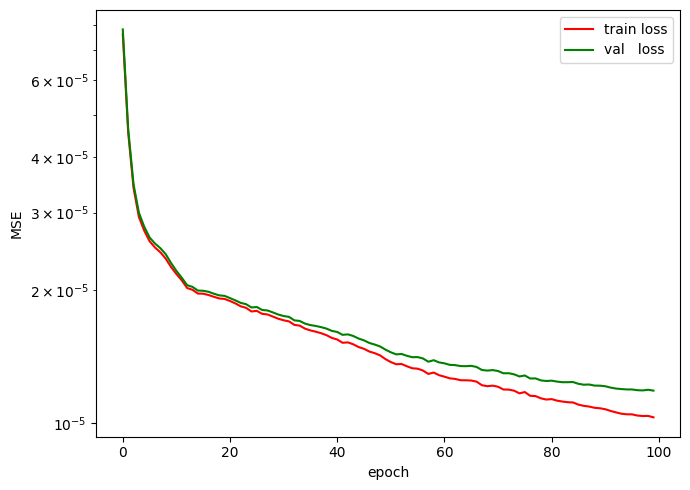

In [19]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.plot( trn_losses, label="train loss", color="red" )
axs.plot( val_losses, label="val   loss", color="green" )

axs.set_yscale('log')

axs.set_xlabel( "epoch" )
axs.set_ylabel( "MSE" )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks )

yticks = axs.get_yticks()

axs.legend( loc='best' )

fig.tight_layout()

We observe that both our train and validation loss decrease without deviating much from eachother and also without any stagnation. Thus we can assume that our network indeed learn something.

# (c)

Now we look at the first 4 qcd and top jets of our test dataset. For all 8 images we plot the original image as well as the predicted image of our model.

In [20]:
n_jets = 4
in_qcd_jets = z_test_p[ y_test==0.0 ][ 0:4 ]
in_top_jets = z_test_p[ y_test==1.0 ][ 0:4 ]
out_qcd_jets = model( in_qcd_jets ).detach().numpy()
out_top_jets = model( in_top_jets ).detach().numpy()
in_qcd_jets = in_qcd_jets.detach().numpy()
in_top_jets = in_top_jets.detach().numpy()

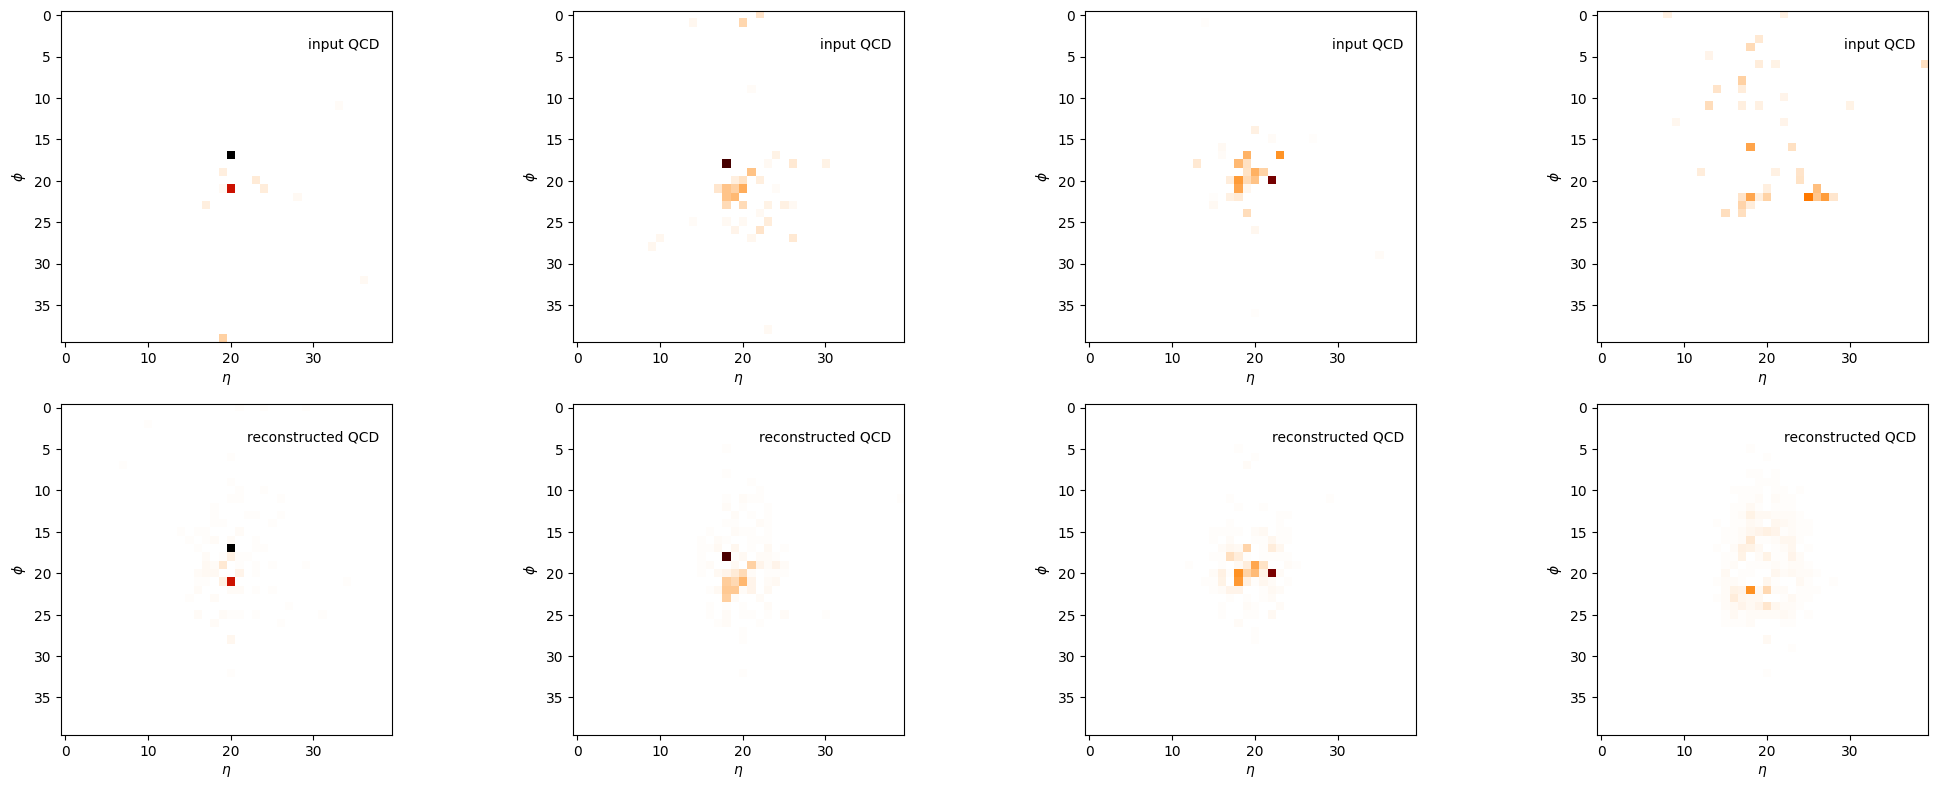

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( in_qcd_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[1][i].imshow( out_qcd_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[0][i].set_xlabel( '$\eta$' )
    axs[0][i].set_ylabel( '$\phi$' )
    axs[1][i].set_xlabel( '$\eta$' )
    axs[1][i].set_ylabel( '$\phi$')
    axs[0][i].text( 38, 4, "input QCD", ha='right' )
    axs[0][i].tick_params( )
    axs[1][i].text( 38, 4, "reconstructed QCD", ha='right' )
    axs[1][i].tick_params( )

fig.tight_layout()
fig.show()

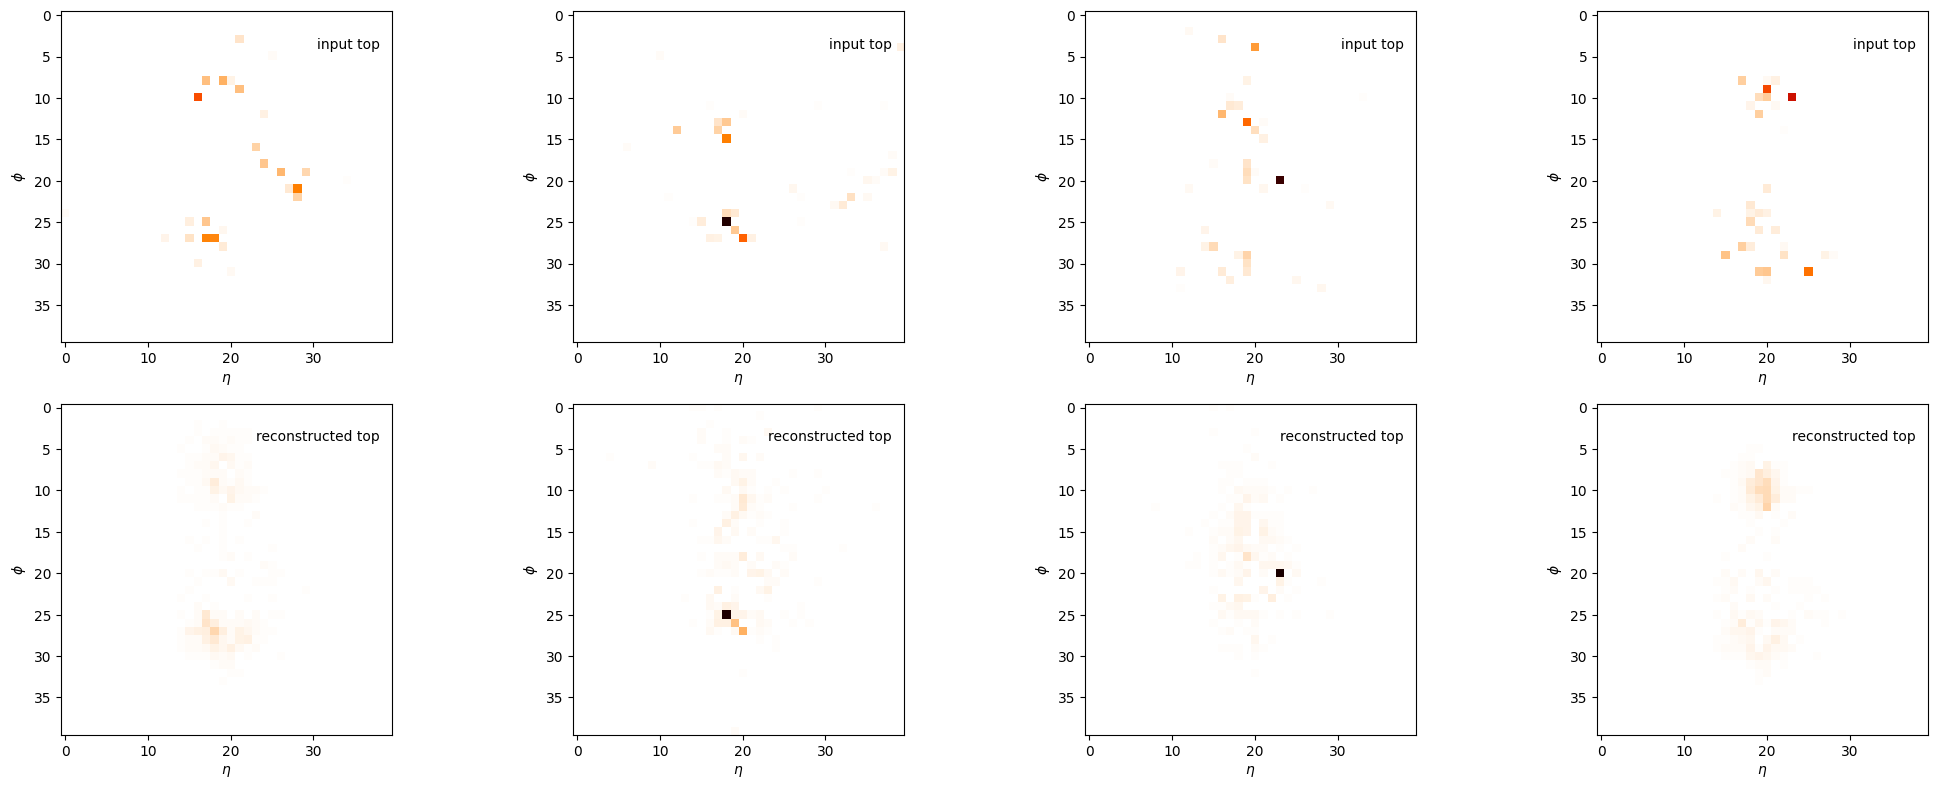

In [22]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( in_top_jets[i].reshape(40,40), cmap='gist_heat_r', vmin=0.0, vmax=0.4 )
    axs[1][i].imshow( out_top_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[0][i].set_xlabel( '$\eta$' )
    axs[0][i].set_ylabel( '$\phi$' )
    axs[1][i].set_xlabel( '$\eta$' )
    axs[1][i].set_ylabel( '$\phi$' )
    axs[0][i].text( 38, 4, "input top", ha='right' )
    axs[0][i].tick_params( )
    axs[1][i].text( 38, 4, "reconstructed top", ha='right' )
    axs[1][i].tick_params( )


fig.tight_layout()
fig.show()

We observe, that for both QCD and Top jets our network is able to predict constituents with a high pT value (at least high compared to all other constituents) accuratly. However, for QCD jets it predicts the other constituents better than for Top jets. This can be seen when we look at the first three QCD jets, where the other constituents are captured still reasonably well, and then compare it with the second and third top jet, where we clearly observe a worse prediction (we compare these jets since they have a constituent with high pT). That QCD jets are better reconstructed is expected because we train the autoencoder only on QCD jets and not om Top jets.

# (d)

In [23]:
test_pred = model( z_test_p ).detach()

test_loss = nn.MSELoss( reduce=False )
test_mse = test_loss( test_pred, z_test_p )

In [24]:
test_mse.shape

torch.Size([30000, 1600])

In [25]:
test_mse = torch.mean( test_mse, dim=-1)

In [26]:
n_jets = 4
in_qcd_jets = z_test_p[ y_test==0.0 ][ 0:4 ]
in_top_jets = z_test_p[ y_test==1.0 ][ 0:4 ]
out_qcd_jets = model( in_qcd_jets )
out_top_jets = model( in_top_jets )
mse_qcd_jets = test_loss( in_qcd_jets, out_qcd_jets ).detach().numpy()
mse_top_jets = test_loss( in_top_jets, out_top_jets ).detach().numpy()
in_qcd_jets = in_qcd_jets.detach().numpy()
in_top_jets = in_top_jets.detach().numpy()

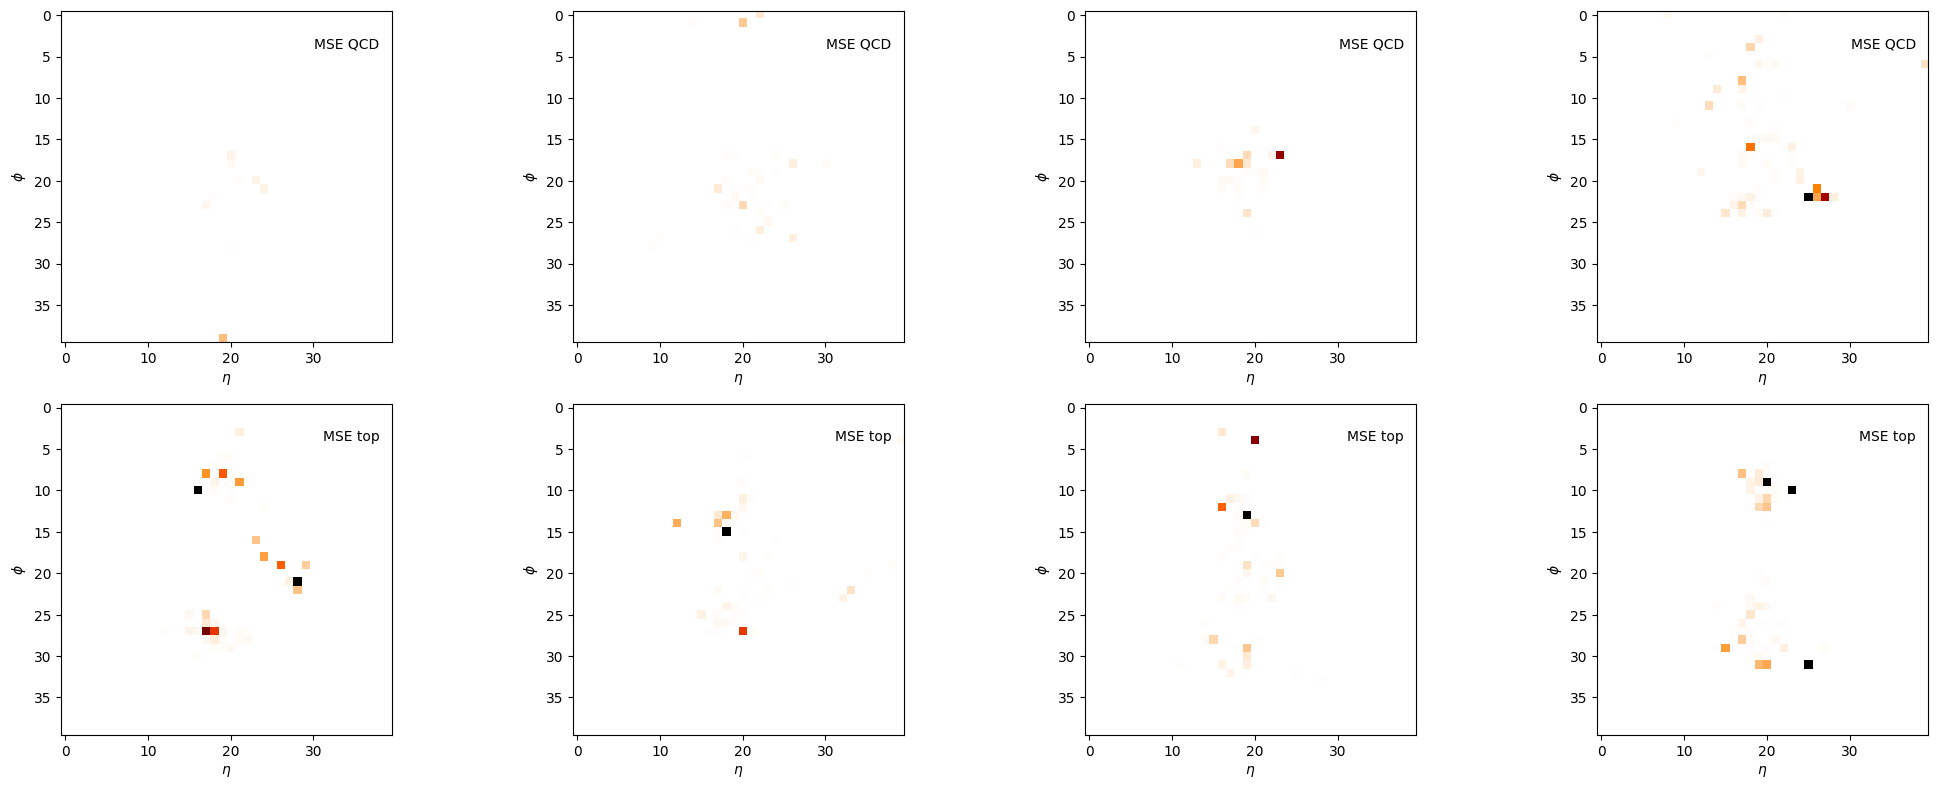

In [27]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( mse_qcd_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.01 )
    axs[1][i].imshow( mse_top_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.01 )
    axs[0][i].set_xlabel( '$\eta$' )
    axs[0][i].set_ylabel( '$\phi$' )
    axs[1][i].set_xlabel( '$\eta$' )
    axs[1][i].set_ylabel( '$\phi$' )
    axs[0][i].text( 38, 4, "MSE QCD", ha='right' )
    axs[0][i].tick_params( )
    axs[1][i].text( 38, 4, "MSE top", ha='right' )
    axs[1][i].tick_params( )

fig.tight_layout()
fig.show()

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

def closest_point(array, tpr_p=0.3):
    dist = ((array-tpr_p)**2)
    return np.argmin(dist)

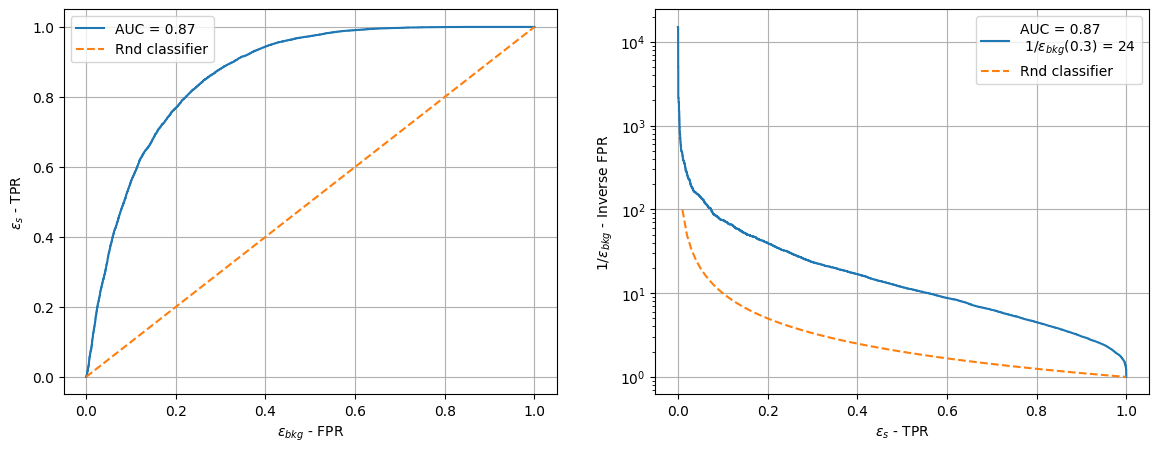

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve(y_test, test_mse)
auc_score = roc_auc_score(y_test, test_mse)
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR')
ax[0].set_ylabel('$\epsilon_{s}$ - TPR')

ax[1].set_xlabel('$\epsilon_{s}$ - TPR')
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR')
for i in range(len(ax)):
    ax[i].legend()
    ax[i].tick_params()
    ax[i].grid('on')

Looking at the pixel-wise MSE shows as well that QCD jets are better reconstructed, because we have fewer pixels with large deviations. Plotting the ROC curve we get AUC = 0.87, which means, that our autoencoder is able to distinguish between QCD and Top jets reasonably well although not perfectly (then AUC would be 1).

# (e)

## (a)

In [30]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_train_qcd = constit_to_img( X_train_qcd, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
z_val_qcd = constit_to_img( X_val_qcd, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising


In [31]:
print( "Train data shape: " + str(z_train.shape) )
print( "Train data (qcd-only) shape: " + str(z_train_qcd.shape) )
print( "Val data shape: " + str(z_val.shape) )
print( "Val data (qcd-only) shape: " + str(z_val_qcd.shape) )
print( "Test data shape: " + str(z_test.shape) )

Train data shape: (30000, 40, 40)
Train data (qcd-only) shape: (14960, 40, 40)
Val data shape: (30000, 40, 40)
Val data (qcd-only) shape: (14460, 40, 40)
Test data shape: (30000, 40, 40)


In [32]:
z_train_p = torch.Tensor( z_train.reshape(-1, 1, 40,40) )
z_train_qcd_p = torch.Tensor( z_train_qcd.reshape(-1, 1, 40,40) )
z_val_p = torch.Tensor( z_val.reshape(-1, 1, 40,40) )
z_val_qcd_p = torch.Tensor( z_val_qcd.reshape(-1, 1, 40,40) )
z_test_p = torch.Tensor( z_test.reshape(-1, 1, 40,40) )
y_train_p = torch.Tensor( y_train ).unsqueeze(-1)
y_val_p = torch.Tensor( y_val ).unsqueeze(-1)
y_test_p = torch.Tensor( y_test ).unsqueeze(-1)

In [33]:
trn_dataset = topcloud_bkg_dataset( z_train_qcd_p )
val_dataset = topcloud_bkg_dataset( z_val_qcd_p )
tst_dataset = topcloud_sig_dataset( z_test_p, y_test_p.unsqueeze(-1) )

In [34]:
trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=False )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=False )

In [35]:
class JetCNN( torch.nn.Module ):

    def __init__( self, in_ch=1, ch_1=10, ch_2=5, lin1=2000, lin2=100, bottleneck_size=20, ker_s=5 ):
        super( JetCNN, self ).__init__()

        self.enc_conv1 = nn.Conv2d( in_ch, ch_1, kernel_size=ker_s, bias=True, stride=1, padding=2 )
        self.enc_prelu1 = nn.PReLU()
        self.enc_max1 = nn.MaxPool2d(kernel_size=2)
        self.enc_conv2 = nn.Conv2d( ch_1, ch_2, kernel_size=ker_s, bias=True, stride=1, padding=2 )
        self.enc_prelu2 = nn.PReLU()
        # view -> image to flatten
        self.enc_layer1 = nn.Linear( lin1, lin2 )
        self.enc_prelu3 = nn.PReLU()
        self.enc_layer2 = nn.Linear( lin2, bottleneck_size )

        self.dec_layer1 = nn.Linear( bottleneck_size, lin2 )
        self.dec_prelu1 = nn.PReLU()
        self.dec_layer2 = nn.Linear( lin2, lin1 )
        self.dec_prelu2 = nn.PReLU()
        # view -> flatten to image
        self.dec_conv1 = nn.ConvTranspose2d( ch_2, ch_1, kernel_size=ker_s, bias=True, stride=1, padding=2 )
        self.dec_prelu3 = nn.PReLU()
        self.dec_ups1 = nn.Upsample( scale_factor=2 )
        self.dec_conv2 = nn.ConvTranspose2d( ch_1, in_ch, kernel_size=ker_s, bias=True, stride=1, padding=2 )


    def forward( self, batch ):

        x = self.encode( batch )
        x = self.decode( x )

        return x

    def encode( self, batch ):

        x = self.enc_conv1( batch )
        x = self.enc_prelu1( x )
        x = self.enc_max1( x )
        x = self.enc_conv2( x )
        x = self.enc_prelu2( x )
        x = x.view(-1,2000) # batch size, 5 channels with 20x20 pixels = 2000
        x = self.enc_layer1( x )
        x = self.enc_prelu3( x )
        x = self.enc_layer2( x )

        return x

    def decode( self, batch ):

        x = self.dec_layer1( batch )
        x = self.dec_prelu1( x )
        x = self.dec_layer2( x )
        x = self.dec_prelu2( x )
        x = x.view(-1,5,20,20) # batch size, channels = 5, image size = 20x20
        x = self.dec_conv1( x )
        x = self.dec_prelu3( x )
        x = self.dec_ups1( x )
        x = self.dec_conv2( x )

        return x

Our network looks as follows:

1. ) 1@40x40 -> 10@40x40 -> 10@20x20 -> 5@20x20 -> 2000 -> 100 -> 20
2. ) 20 -> 100 -> 2000 -> 5@20x20 -> 10@20x20 -> 10@40x40 -> 1@40x40

We use PReLU as activation function and a kernel size of 5 for the convolutional layers.

## (b)

In [36]:
loss_fn = nn.MSELoss()
epochs = 10

# initialise the model and the optimizer
model = JetCNN()
learning_rate = 0.001
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in tqdm(range(epochs)):
    train_epoch( trn_dataloader, model, loss_fn, optimizer )
    trn_loss = trn_pass( trn_dataloader, model, loss_fn )
    trn_losses.append( trn_loss )
    val_loss = val_pass( val_dataloader, model, loss_fn )
    val_losses.append( val_loss )

-----------------------------------------------
model architecture 
-----------------------------------------------
JetCNN(
  (enc_conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc_prelu1): PReLU(num_parameters=1)
  (enc_max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Conv2d(10, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc_prelu2): PReLU(num_parameters=1)
  (enc_layer1): Linear(in_features=2000, out_features=100, bias=True)
  (enc_prelu3): PReLU(num_parameters=1)
  (enc_layer2): Linear(in_features=100, out_features=20, bias=True)
  (dec_layer1): Linear(in_features=20, out_features=100, bias=True)
  (dec_prelu1): PReLU(num_parameters=1)
  (dec_layer2): Linear(in_features=100, out_features=2000, bias=True)
  (dec_prelu2): PReLU(num_parameters=1)
  (dec_conv1): ConvTranspose2d(5, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dec_prelu3): PReLU(num_parameters=1)
  (dec_ups1): Upsample

  0%|          | 0/10 [00:00<?, ?it/s]

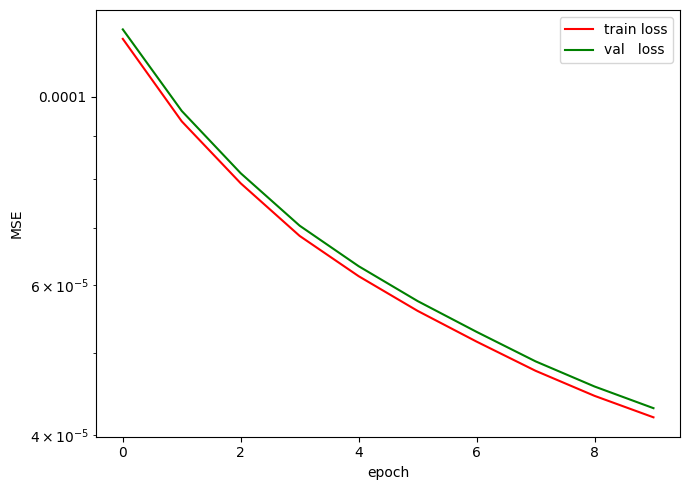

In [37]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.plot( trn_losses, label="train loss", color="red" )
axs.plot( val_losses, label="val   loss", color="green" )

axs.set_yscale('log')

axs.set_xlabel( "epoch" )
axs.set_ylabel( "MSE" )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks )

axs.legend( loc='best' )

fig.tight_layout()

We see ...

## (c)

In [38]:
n_jets = 4
in_qcd_jets = z_test_p[ y_test==0.0 ][ 0:4 ]
in_top_jets = z_test_p[ y_test==1.0 ][ 0:4 ]
out_qcd_jets = model( in_qcd_jets ).detach().view(-1,40,40).numpy()
out_top_jets = model( in_top_jets ).detach().view(-1,40,40).numpy()
in_qcd_jets = in_qcd_jets.detach().view(-1,40,40).numpy()
in_top_jets = in_top_jets.detach().view(-1,40,40).numpy()

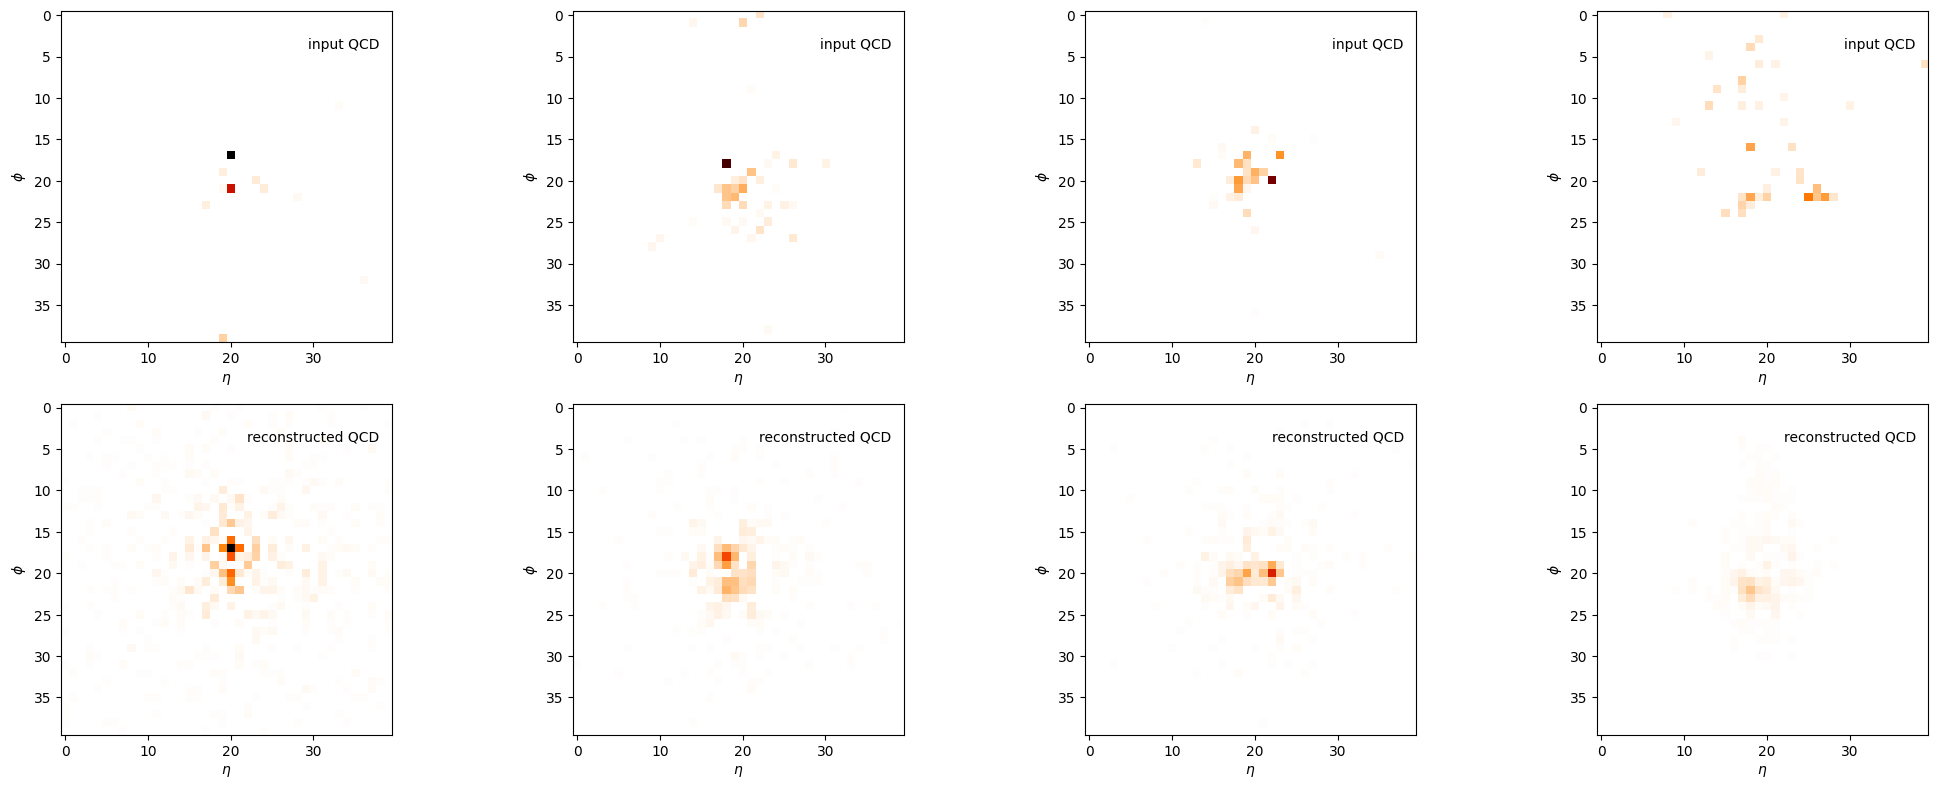

In [39]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( in_qcd_jets[i], cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[1][i].imshow( out_qcd_jets[i], cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[0][i].set_xlabel( '$\eta$' )
    axs[0][i].set_ylabel( '$\phi$' )
    axs[1][i].set_xlabel( '$\eta$' )
    axs[1][i].set_ylabel( '$\phi$' )
    axs[0][i].text( 38, 4, "input QCD", ha='right' )
    axs[0][i].tick_params( )
    axs[1][i].text( 38, 4, "reconstructed QCD", ha='right' )
    axs[1][i].tick_params( )

fig.tight_layout()
fig.show()

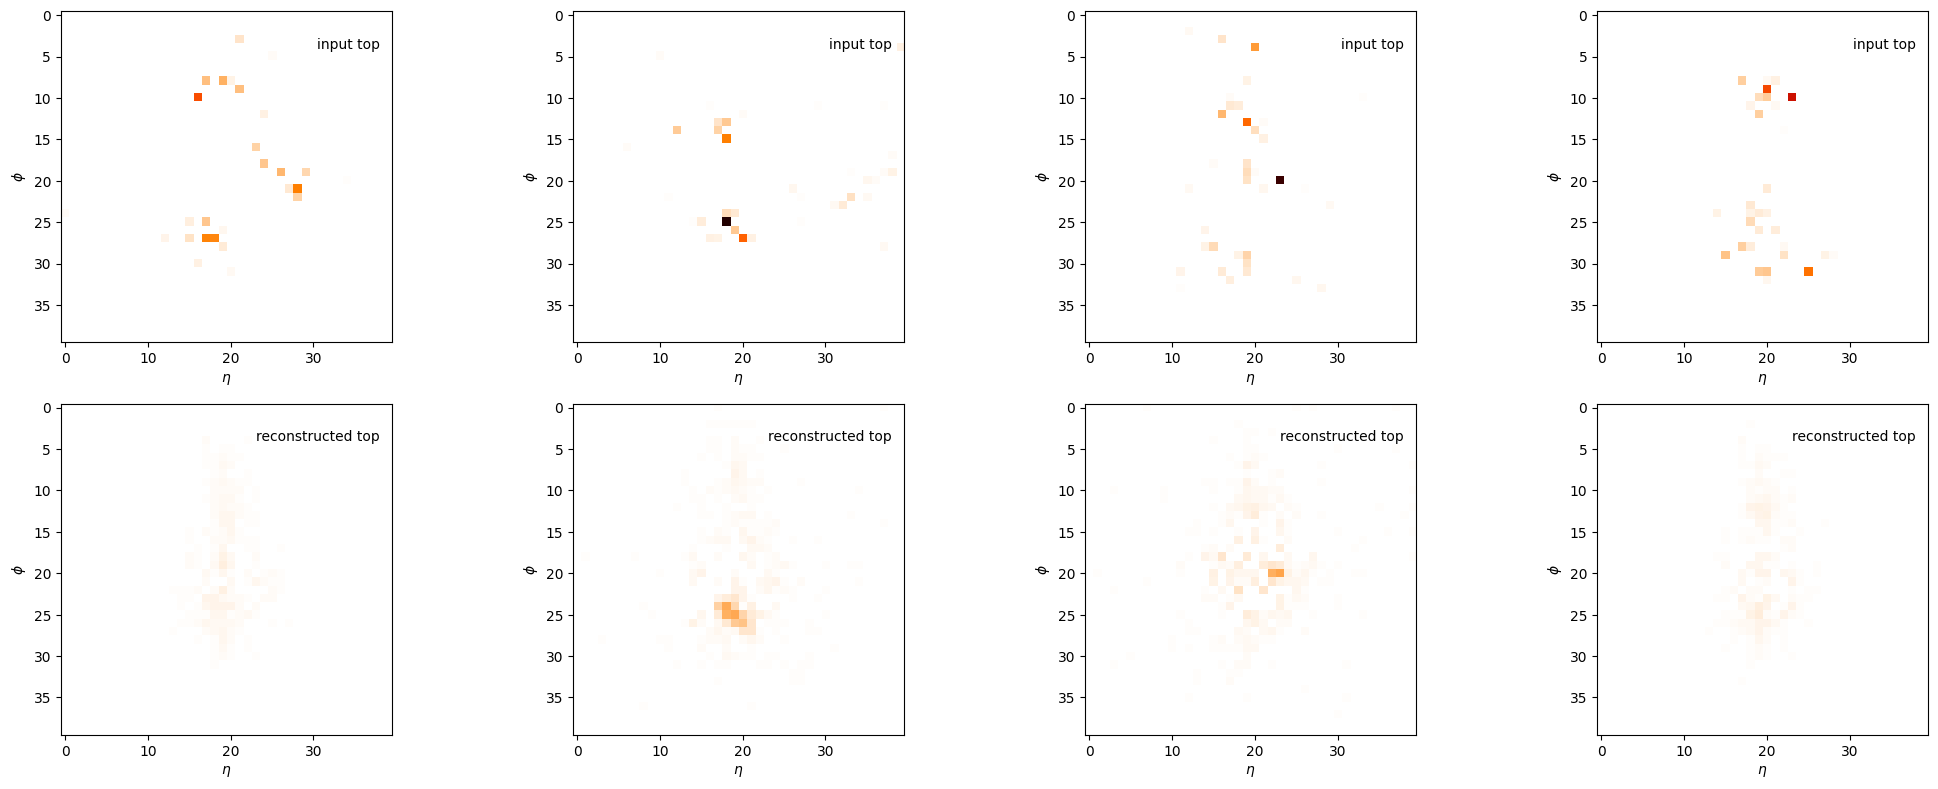

In [40]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( in_top_jets[i], cmap='gist_heat_r', vmin=0.0, vmax=0.4 )
    axs[1][i].imshow( out_top_jets[i], cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[0][i].set_xlabel( '$\eta$' )
    axs[0][i].set_ylabel( '$\phi$' )
    axs[1][i].set_xlabel( '$\eta$' )
    axs[1][i].set_ylabel( '$\phi$' )
    axs[0][i].text( 38, 4, "input top", ha='right' )
    axs[0][i].tick_params( )
    axs[1][i].text( 38, 4, "reconstructed top", ha='right' )
    axs[1][i].tick_params( )


fig.tight_layout()
fig.show()

Although we trained our autoencoder on Top jets, it looks like it still predicts QCD jets better.

## (d)

In [ ]:
test_pred = model( z_test_p ).detach().view(-1,40,40)

test_loss = nn.MSELoss( reduce=False )
test_mse = test_loss( test_pred, z_test_p )

In [ ]:
test_mse.shape

In [ ]:
test_mse = torch.mean( test_mse, dim=-1)

In [ ]:
n_jets = 4
in_qcd_jets = z_test_p[ y_test==0.0 ][ 0:4 ]
in_top_jets = z_test_p[ y_test==1.0 ][ 0:4 ]
out_qcd_jets = model( in_qcd_jets )
out_top_jets = model( in_top_jets )
mse_qcd_jets = test_loss( in_qcd_jets, out_qcd_jets ).detach().view(-1,40,40).numpy()
mse_top_jets = test_loss( in_top_jets, out_top_jets ).detach().view(-1,40,40).numpy()
in_qcd_jets = in_qcd_jets.detach().view(-1,40,40).numpy()
in_top_jets = in_top_jets.detach().view(-1,40,40).numpy()

In [ ]:
mse_qcd_jets.shape

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( mse_qcd_jets[i], cmap='gist_heat_r',  vmin=0.0, vmax=0.01 )
    axs[1][i].imshow( mse_top_jets[i], cmap='gist_heat_r',  vmin=0.0, vmax=0.01 )
    axs[0][i].set_xlabel( '$\eta$' )
    axs[0][i].set_ylabel( '$\phi$' )
    axs[1][i].set_xlabel( '$\eta$' )
    axs[1][i].set_ylabel( '$\phi$' )
    axs[0][i].text( 38, 4, "MSE QCD", ha='right' )
    axs[0][i].tick_params( )
    axs[1][i].text( 38, 4, "MSE top", ha='right' )
    axs[1][i].tick_params( )

fig.tight_layout()
fig.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve(y_test, test_mse)
auc_score = roc_auc_score(y_test, test_mse)
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR')
ax[0].set_ylabel('$\epsilon_{s}$ - TPR')

ax[1].set_xlabel('$\epsilon_{s}$ - TPR')
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR')
for i in range(len(ax)):
    ax[i].legend()
    ax[i].tick_params()
    ax[i].grid('on')

We see ...

# (f)

We can simply copy the above code and replace "qcd" with "top". Defined functions and classes don't have to be redefined.

## (a) + (b)

In [ ]:
X_train_top = X_train[ y_train == 1.0 ]
X_val_top = X_val[ y_val == 1.0 ]

In [ ]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_train = z_train.reshape( (z_train.shape[0],-1) )
z_train_top = constit_to_img( X_train_top, 50, True, True, True )
z_train_top = z_train_top.reshape( (z_train_top.shape[0],-1) )
z_val = constit_to_img( X_val, 50, True, True, True )
z_val = z_val.reshape( (z_val.shape[0],-1) )
z_val_top = constit_to_img( X_val_top, 50, True, True, True )
z_val_top = z_val_top.reshape( (z_val_top.shape[0],-1) )
z_test = constit_to_img( X_test, 50, True, True, True )
z_test = z_test.reshape( (z_test.shape[0],-1) )

In [ ]:
print( "Train data shape: " + str(z_train.shape) )
print( "Train data (top-only) shape: " + str(z_train_top.shape) )
print( "Val data shape: " + str(z_val.shape) )
print( "Val data (top-only) shape: " + str(z_val_top.shape) )
print( "Test data shape: " + str(z_test.shape) )

In [ ]:
z_train_p = torch.Tensor( z_train )
z_train_top_p = torch.Tensor( z_train_top )
z_val_p = torch.Tensor( z_val )
z_val_top_p = torch.Tensor( z_val_top )
z_test_p = torch.Tensor( z_test )
y_train_p = torch.Tensor( y_train )
y_val_p = torch.Tensor( y_val )
y_test_p = torch.Tensor( y_test )

In [ ]:
trn_dataset = topcloud_bkg_dataset( z_train_top_p )
val_dataset = topcloud_bkg_dataset( z_val_top_p )
tst_dataset = topcloud_sig_dataset( z_test_p, y_test_p.unsqueeze(-1) )

In [ ]:
trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=False )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=False )

In [ ]:
loss_fn = nn.MSELoss()
epochs = 100

# initialise the model and the optimizer
model = JetAutoEncoder( 1600, 400, 20 )
learning_rate = 0.001
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in tqdm(range(epochs)):
    train_epoch( trn_dataloader, model, loss_fn, optimizer )
    trn_loss = trn_pass( trn_dataloader, model, loss_fn )
    trn_losses.append( trn_loss )
    val_loss = val_pass( val_dataloader, model, loss_fn )
    val_losses.append( val_loss )

In [ ]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.plot( trn_losses, label="train loss", color="red" )
axs.plot( val_losses, label="val   loss", color="green" )

axs.set_yscale('log')

axs.set_xlabel( "epoch" )
axs.set_ylabel( "MSE" )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks )

axs.legend( loc='best' )

fig.tight_layout()

We see ...

## (c)

In [ ]:
n_jets = 4
in_qcd_jets = z_test_p[ y_test==0.0 ][ 0:4 ]
in_top_jets = z_test_p[ y_test==1.0 ][ 0:4 ]
out_qcd_jets = model( in_qcd_jets ).detach().numpy()
out_top_jets = model( in_top_jets ).detach().numpy()
in_qcd_jets = in_qcd_jets.detach().numpy()
in_top_jets = in_top_jets.detach().numpy()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( in_qcd_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[1][i].imshow( out_qcd_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[0][i].set_xlabel( '$\eta$' )
    axs[0][i].set_ylabel( '$\phi$' )
    axs[1][i].set_xlabel( '$\eta$' )
    axs[1][i].set_ylabel( '$\phi$' )
    axs[0][i].text( 38, 4, "input QCD", ha='right' )
    axs[0][i].tick_params()
    axs[1][i].text( 38, 4, "reconstructed QCD", ha='right' )
    axs[1][i].tick_params( )

fig.tight_layout()
fig.show()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( in_top_jets[i].reshape(40,40), cmap='gist_heat_r', vmin=0.0, vmax=0.4 )
    axs[1][i].imshow( out_top_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[0][i].set_xlabel( '$\eta$' )
    axs[0][i].set_ylabel( '$\phi$' )
    axs[1][i].set_xlabel( '$\eta$' )
    axs[1][i].set_ylabel( '$\phi$' )
    axs[0][i].text( 38, 4, "input top", ha='right' )
    axs[0][i].tick_params( )
    axs[1][i].text( 38, 4, "reconstructed top", ha='right' )
    axs[1][i].tick_params( )


fig.tight_layout()
fig.show()

We see ...

## (d)

In [ ]:
test_pred = model( z_test_p ).detach()

test_loss = nn.MSELoss( reduce=False )
test_mse = test_loss( test_pred, z_test_p )

In [ ]:
test_mse.shape

In [ ]:
test_mse = torch.mean( test_mse, dim=-1)

In [ ]:
n_jets = 4
in_qcd_jets = z_test_p[ y_test==0.0 ][ 0:4 ]
in_top_jets = z_test_p[ y_test==1.0 ][ 0:4 ]
out_qcd_jets = model( in_qcd_jets )
out_top_jets = model( in_top_jets )
mse_qcd_jets = test_loss( in_qcd_jets, out_qcd_jets ).detach().numpy()
mse_top_jets = test_loss( in_top_jets, out_top_jets ).detach().numpy()
in_qcd_jets = in_qcd_jets.detach().numpy()
in_top_jets = in_top_jets.detach().numpy()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( mse_qcd_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.01 )
    axs[1][i].imshow( mse_top_jets[i].reshape(40,40), cmap='gist_heat_r',  vmin=0.0, vmax=0.01 )
    axs[0][i].set_xlabel( '$\eta$' )
    axs[0][i].set_ylabel( '$\phi$')
    axs[1][i].set_xlabel( '$\eta$')
    axs[1][i].set_ylabel( '$\phi$' )
    axs[0][i].text( 38, 4, "MSE QCD", ha='right' )
    axs[0][i].tick_params( )
    axs[1][i].text( 38, 4, "MSE top", ha='right' )
    axs[1][i].tick_params( )

fig.tight_layout()
fig.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve(y_test, test_mse)
auc_score = roc_auc_score(y_test, test_mse)
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR')
ax[0].set_ylabel('$\epsilon_{s}$ - TPR')

ax[1].set_xlabel('$\epsilon_{s}$ - TPR')
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR')
for i in range(len(ax)):
    ax[i].legend()
    ax[i].tick_params()
    ax[i].grid('on')

We see ...

## (e)

### (a) + (b)

In [ ]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_train_top = constit_to_img( X_train_top, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
z_val_top = constit_to_img( X_val_top, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )

In [ ]:
print( "Train data shape: " + str(z_train.shape) )
print( "Train data (top-only) shape: " + str(z_train_top.shape) )
print( "Val data shape: " + str(z_val.shape) )
print( "Val data (top-only) shape: " + str(z_val_top.shape) )
print( "Test data shape: " + str(z_test.shape) )

In [ ]:
z_train_p = torch.Tensor( z_train.reshape(-1, 1, 40,40) )
z_train_top_p = torch.Tensor( z_train_top.reshape(-1, 1, 40,40) )
z_val_p = torch.Tensor( z_val.reshape(-1, 1, 40,40) )
z_val_top_p = torch.Tensor( z_val_top.reshape(-1, 1, 40,40) )
z_test_p = torch.Tensor( z_test.reshape(-1, 1, 40,40) )
y_train_p = torch.Tensor( y_train ).unsqueeze(-1)
y_val_p = torch.Tensor( y_val ).unsqueeze(-1)
y_test_p = torch.Tensor( y_test ).unsqueeze(-1)

In [ ]:
trn_dataset = topcloud_bkg_dataset( z_train_top_p )
val_dataset = topcloud_bkg_dataset( z_val_top_p )
tst_dataset = topcloud_sig_dataset( z_test_p, y_test_p.unsqueeze(-1) )

In [ ]:
trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=False )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=False )

In [ ]:
loss_fn = nn.MSELoss()
epochs = 10

# initialise the model and the optimizer
model = JetCNN()
learning_rate = 0.001
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

for t in tqdm(range(epochs)):
    train_epoch( trn_dataloader, model, loss_fn, optimizer )
    trn_loss = trn_pass( trn_dataloader, model, loss_fn )
    trn_losses.append( trn_loss )
    val_loss = val_pass( val_dataloader, model, loss_fn )
    val_losses.append( val_loss )

In [ ]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.plot( trn_losses, label="train loss", color="red" )
axs.plot( val_losses, label="val   loss", color="green" )

axs.set_yscale('log')

axs.set_xlabel( "epoch" )
axs.set_ylabel( "MSE" )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks )

axs.legend( loc='best' )

fig.tight_layout()

We see ...

### (c)

In [ ]:
n_jets = 4
in_qcd_jets = z_test_p[ y_test==0.0 ][ 0:4 ]
in_top_jets = z_test_p[ y_test==1.0 ][ 0:4 ]
out_qcd_jets = model( in_qcd_jets ).detach().view(-1,40,40).numpy()
out_top_jets = model( in_top_jets ).detach().view(-1,40,40).numpy()
in_qcd_jets = in_qcd_jets.detach().view(-1,40,40).numpy()
in_top_jets = in_top_jets.detach().view(-1,40,40).numpy()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( in_qcd_jets[i], cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[1][i].imshow( out_qcd_jets[i], cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[0][i].set_xlabel( '$\eta$' )
    axs[0][i].set_ylabel( '$\phi$' )
    axs[1][i].set_xlabel( '$\eta$' )
    axs[1][i].set_ylabel( '$\phi$' )
    axs[0][i].text( 38, 4, "input QCD", ha='right' )
    axs[0][i].tick_params( )
    axs[1][i].text( 38, 4, "reconstructed QCD", ha='right' )
    axs[1][i].tick_params( )

fig.tight_layout()
fig.show()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( in_top_jets[i], cmap='gist_heat_r', vmin=0.0, vmax=0.4 )
    axs[1][i].imshow( out_top_jets[i], cmap='gist_heat_r',  vmin=0.0, vmax=0.4 )
    axs[0][i].set_xlabel( '$\eta$' )
    axs[0][i].set_ylabel( '$\phi$' )
    axs[1][i].set_xlabel( '$\eta$' )
    axs[1][i].set_ylabel( '$\phi$' )
    axs[0][i].text( 38, 4, "input top", ha='right' )
    axs[0][i].tick_params( )
    axs[1][i].text( 38, 4, "reconstructed top", ha='right' )
    axs[1][i].tick_params( )


fig.tight_layout()
fig.show()

We see ...

### (d)

In [ ]:
test_pred = model( z_test_p ).detach().view(-1,40,40)

test_loss = nn.MSELoss( reduce=False )
test_mse = test_loss( test_pred, z_test_p )

In [ ]:
test_mse.shape

In [ ]:
test_mse = torch.mean( test_mse, dim=-1)

In [ ]:
n_jets = 4
in_qcd_jets = z_test_p[ y_test==0.0 ][ 0:4 ]
in_top_jets = z_test_p[ y_test==1.0 ][ 0:4 ]
out_qcd_jets = model( in_qcd_jets )
out_top_jets = model( in_top_jets )
mse_qcd_jets = test_loss( in_qcd_jets, out_qcd_jets ).detach().view(-1,40,40).numpy()
mse_top_jets = test_loss( in_top_jets, out_top_jets ).detach().view(-1,40,40).numpy()
in_qcd_jets = in_qcd_jets.detach().view(-1,40,40).numpy()
in_top_jets = in_top_jets.detach().view(-1,40,40).numpy()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(21,8))

for i in range(4):
    axs[0][i].imshow( mse_qcd_jets[i], cmap='gist_heat_r',  vmin=0.0, vmax=0.01 )
    axs[1][i].imshow( mse_top_jets[i], cmap='gist_heat_r',  vmin=0.0, vmax=0.01 )
    axs[0][i].set_xlabel( '$\eta$' )
    axs[0][i].set_ylabel( '$\phi$' )
    axs[1][i].set_xlabel( '$\eta$' )
    axs[1][i].set_ylabel( '$\phi$' )
    axs[0][i].text( 38, 4, "MSE QCD", ha='right' )
    axs[0][i].tick_params()
    axs[1][i].text( 38, 4, "MSE top", ha='right' )
    axs[1][i].tick_params( )

fig.tight_layout()
fig.show()

We see ...

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve(y_test, test_mse)
auc_score = roc_auc_score(y_test, test_mse)
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR')
ax[0].set_ylabel('$\epsilon_{s}$ - TPR')

ax[1].set_xlabel('$\epsilon_{s}$ - TPR')
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR')
for i in range(len(ax)):
    ax[i].legend()
    ax[i].tick_params()
    ax[i].grid('on')

We see ...

We conclude ...